# **Data Generator :** 

**CLave :** En un proyecto de Procesamiento de Grandes Volúmenes de Datos (PGVD) un generador de datos es parte clave y necesaria porque se necesita simular un entorno de **streaming en tiempo real** (como si los tweets llegaran en vivo).


**OBJETIVO :**
Construcción de un generador coherente con la estadística de los datos reales (twiter_training.csv y twiter_validation.csv).

- Crear un generador de tweets sintéticos (simulados) que produzca datos en tiempo real (cada segundo o en ráfagas) con estructura parecida a los tweets reales, y que pueda enviar a:
    - un archivo CSV/JSON (para pruebas batch),
    - o directamente a Kafka (para streaming en Spark).

- Después, sobre esos datos se debe realizar:
    - estadísticas descriptivas,
    - limpieza,
    - y flujo de procesamiento (Spark o Hadoop).

#### ETAPA 1 — Entender los datasets originales

Es necesario analizar estadísticamente los CSV reales para identificar:

| Tipo de estadística                    | Qué buscamos                          | Ejemplo                                |
|---------------------------------------|---------------------------------------|----------------------------------------|
| Distribución de sentimientos          | % de positivos, negativos, neutros    | 60% pos, 30% neg, 10% neutro           |
| Longitud de los textos                | Promedio, desviación estándar         | media=80 caracteres                    |
| Frecuencia de hashtags o entidades    | Top 10 hashtags más usados            | #COVID19, #AI, #Sports                 |
| Idiomas / regiones (si existen)       | Conteo por país o idioma              | en=70%, es=30%                         |
| Palabras más frecuentes               | nubes de palabras y tokens clave      | "love", "hate", "great"               |

→ Estas estadísticas servirán como parámetros para el generador.  
Así, los datos sintéticos mantendrán el **mismo comportamiento** que los reales.

#### ETAPA 2 — Calcular las estadísticas base

Leer los CSV y analizar sus distribuciones.

In [1]:
import pandas as pd
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [35]:
train = pd.read_csv("data/twitter_training.csv")
valid = pd.read_csv("data/twitter_validation.csv")

train.columns = train.columns.str.strip()
valid.columns = valid.columns.str.strip()

train.head()

,Tweet ID,Entity,Sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [36]:
valid.head()

,Tweet ID,Entity,Sentiment,Tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [39]:
df = pd.concat([train, valid])

df.head()

,Tweet ID,Entity,Sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75682 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       75682 non-null  int64 
 1   Entity         75682 non-null  object
 2   Sentiment      75682 non-null  object
 3   Tweet content  74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


In [41]:
print(df["Sentiment"])

0        Positive
1        Positive
2        Positive
3        Positive
4        Positive
          ...    
995    Irrelevant
996    Irrelevant
997      Positive
998      Positive
999       Neutral
Name: Sentiment, Length: 75682, dtype: object


In [ ]:
#Distribución porcentual de sentimientos
print(df['Sentiment'].value_counts(normalize=True))

Sentiment
Negative      0.301366
Positive      0.278917
Neutral       0.245805
Irrelevant    0.173912
Name: proportion, dtype: float64


In [44]:
#Longitud promedio de los textos
df['text_length'] = df['Tweet content'].astype(str).apply(len)
print("\nLongitud promedio del texto:")
print(df['text_length'].describe())



Longitud promedio del texto:
count    75682.000000
mean       108.139584
std         79.887187
min          1.000000
25%         46.000000
50%         90.000000
75%        152.000000
max        957.000000
Name: text_length, dtype: float64


In [46]:
#Top palabras
def tokenize(text):
    text = re.sub(r"http\S+|@\S+|#\S+", "", str(text).lower())
    words = re.findall(r'\b[a-záéíóúñü]+', text)
    return words

all_words = [w for text in df['Tweet content'] for w in tokenize(text)]
counter = Counter(all_words)
print("\nTop 20 palabras más frecuentes:")
print(counter.most_common(20))


Top 20 palabras más frecuentes:
[('the', 45247), ('i', 36747), ('to', 29477), ('and', 27109), ('a', 24798), ('of', 19823), ('it', 18211), ('is', 18173), ('in', 16020), ('for', 15909), ('this', 14990), ('you', 13254), ('on', 12332), ('my', 12069), ('s', 11426), ('that', 11303), ('com', 10319), ('t', 10232), ('with', 9045), ('game', 8370)]


In [ ]:
import re
from collections import Counter

# Extraer hashtags del texto
def extract_hashtags(text):
    return re.findall(r"#\w+", str(text))

hashtags = [tag.lower() for txt in df["Tweet content"].dropna() for tag in extract_hashtags(txt)]
tag_counts = Counter(hashtags)
print(tag_counts.most_common(50))


[('#apexlegends', 19), ('#rainbowsixsiege', 15), ('#callofduty', 13), ('#twitch', 12), ('#hearthstone', 12), ('#leagueoflegends', 11), ('#fortnite', 11), ('#xbox', 10), ('#gaming', 10), ('#xboxseriesx', 10), ('#ghostreconbreakpoint', 9), ('#ps4share', 9), ('#warzone', 8), ('#modernwarfare', 8), ('#warcraft', 8), ('#xboxshare', 8), ('#ps5', 8), ('#pubg', 7), ('#cyberpunk2077', 7), ('#overwatch', 6), ('#playstation5', 6), ('#dota2', 6), ('#covid19', 5), ('#pubgmobile', 5), ('#streamer', 5), ('#nvidia', 5), ('#xboxone', 5), ('#videogames', 5), ('#games', 4), ('#microsoft', 4), ('#twitchtv', 4), ('#blackopscoldwar', 4), ('#esports', 4), ('#gamer', 4), ('#battlefieldv', 4), ('#amazon', 4), ('#worldofwarcraft', 4), ('#stream', 3), ('#assassinscreed', 3), ('#cod', 3), ('#blizzard', 3), ('#nba2k', 3), ('#playstation', 3), ('#smallstreamercommunity', 3), ('#facebook', 3), ('#mixer', 3), ('#apex', 3), ('#rdr2', 3), ('#battlefield4', 3), ('#nfldropea', 3)]


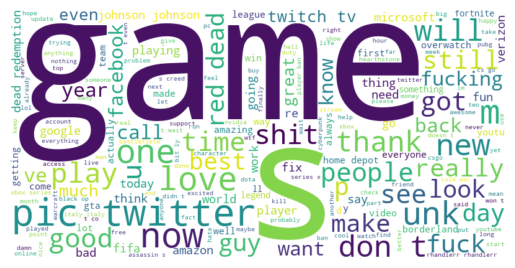

In [49]:
#Nube de palabras
text_corpus = " ".join(all_words)
wc = WordCloud(width=800, height=400, background_color="white").generate(text_corpus)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
#qué palabras aparecen más en cada clase (Sentiment)
from collections import Counter

def top_words_by_sentiment(sentiment_label, n=20):
    subset = df[df['Sentiment'] == sentiment_label]['Tweet content'].dropna()
    words = [w for text in subset for w in tokenize(text)]
    counter = Counter(words)
    return counter.most_common(n)

print("Top palabras - Positive:")
print(top_words_by_sentiment("Positive", 60))
print("\nTop palabras - Negative:")
print(top_words_by_sentiment("Negative", 60))
print("\nTop palabras - Neutral:")
print(top_words_by_sentiment("Neutral", 60))


Top palabras - Positive:
[('the', 12014), ('i', 11784), ('to', 7809), ('and', 7044), ('a', 6064), ('it', 5279), ('of', 5191), ('is', 4590), ('for', 4448), ('this', 4338), ('in', 3920), ('my', 3351), ('s', 3199), ('on', 2858), ('so', 2795), ('you', 2787), ('that', 2766), ('game', 2343), ('with', 2250), ('be', 2144), ('t', 2129), ('com', 2056), ('m', 1884), ('love', 1823), ('me', 1821), ('all', 1811), ('but', 1794), ('was', 1763), ('just', 1713), ('have', 1672), ('good', 1643), ('can', 1505), ('pic', 1448), ('like', 1385), ('are', 1335), ('at', 1309), ('really', 1307), ('twitter', 1273), ('new', 1229), ('out', 1156), ('we', 1155), ('best', 1150), ('not', 1138), ('now', 1132), ('as', 1100), ('one', 1089), ('play', 1071), ('from', 1039), ('time', 1038), ('great', 995), ('more', 962), ('playing', 955), ('will', 942), ('fun', 936), ('get', 924), ('some', 913), ('what', 860), ('games', 857), ('wait', 834), ('about', 828)]

Top palabras - Negative:
[('the', 14205), ('i', 12221), ('to', 9198), 